In [20]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import keras
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

import warnings
warnings.filterwarnings('ignore')

Defining some helper functions:

In [21]:
#To evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, model):
    """
    Cross validation function
    """
    seconds = list()
    results = list()
    result_training = list()
    
    #n_inputs, n_outputs = X.shape[1], y.shape[1]    
    
    # define evaluation procedure (cross validation)
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
    
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        
        scaler = StandardScaler().fit(X_train)

        #Scaling:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Time execution (start)
        start = time.time()
        
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        
        # Time execution (end)
        end = time.time()
        seconds.append(end - start)
        
        # ------ make a prediction on the training set ------
        yhat = model.predict(X_train)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_train, yhat)
        
        # store result
        print('Training>%.3f' % acc)
        result_training.append(acc)
        
        # ------ make a prediction on the test set ------
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        
        # store result
        print('Test>%.3f' % acc)
        results.append(acc)
        
    return seconds, results, result_training

### Importing preprocessed Data:

Let's import the both preprocessed datasets.

In [22]:
dfraw3 = pd.read_csv('Data\preprocessed_keppler_data(knn=3).csv')
dfraw5 = pd.read_csv('Data\preprocessed_keppler_data(knn=5).csv')

dfraw3.head()

,kepid,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,...,koi_steff,koi_tce_plnt_num,koi_model_snr,koi_insol,koi_teq,koi_prad,koi_ror,koi_depth,koi_impact,koi_eccen
0,10797460,CONFIRMED,CANDIDATE,0,0,0,0,9.488036,170.538750,2455003.539,...,5455.0,1.0,35.8,93.59,793.0,2.26,0.022344,615.8,0.146,0.0
1,10797460,CONFIRMED,CANDIDATE,0,0,0,0,54.418383,162.513840,2454995.514,...,5455.0,2.0,25.8,9.11,443.0,2.83,0.027954,874.8,0.586,0.0
2,10811496,CANDIDATE,CANDIDATE,0,0,0,0,19.899140,175.850252,2455008.850,...,5853.0,1.0,76.3,39.30,638.0,14.60,0.154046,10829.0,0.969,0.0
3,10848459,FALSE POSITIVE,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,2455003.308,...,5805.0,1.0,505.6,891.96,1395.0,33.46,0.387394,8079.2,1.276,0.0
4,10854555,CONFIRMED,CANDIDATE,0,0,0,0,2.525592,171.595550,2455004.596,...,6031.0,1.0,40.9,926.16,1406.0,2.75,0.024064,603.3,0.701,0.0


#### Creating the target variables:

In [23]:
def createtarget(series):
    """
    Helper function for the target variable
    """
    conditions = [ ( series == "CONFIRMED" ) | ( (series == "CANDIDATE") ),
               ( series == "FALSE POSITIVE" )
             ]

    choices = [ 1, 0 ]
    
    out = np.select(conditions, choices)
    
    return out

In [24]:
dfraw3['Target'] = createtarget(dfraw3.koi_disposition)

dfraw5['Target'] = createtarget(dfraw5.koi_disposition)

In [25]:
# Deleting the first three columns, since it does not inform the model
select_columns = dfraw3.columns.to_list()[3::]

In [26]:
# Final Dataframes
df3 = dfraw3[select_columns]
df5 = dfraw5[select_columns]

# Training and Validation model (KNN = 3):

In [27]:
X = df3[ select_columns[:-1] ] 

y = df3.Target

In [28]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=1, stratify = y_train1)

In [29]:
# Scaler object for the training data
scaler = StandardScaler().fit(X_train)

# Scaling:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
# Creation of an empty model
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X.columns) ))

# Adding the second hidden layer
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Training the network 
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [31]:
history = classifier.fit(X_train, y_train.values, 
                    epochs=100, batch_size=200,
                    validation_data = (X_test, y_test.values))

Epoch 1/100
20/20 [==============================] - 0s 12ms/step - loss: 0.6811 - accuracy: 0.7866 - val_loss: 0.6539 - val_accuracy: 0.9329
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5711 - accuracy: 0.9419 - val_loss: 0.4711 - val_accuracy: 0.9488
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3114 - accuracy: 0.9529 - val_loss: 0.2984 - val_accuracy: 0.9638
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9712 - val_loss: 0.3244 - val_accuracy: 0.9745
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0790 - accuracy: 0.9801 - val_loss: 0.4024 - val_accuracy: 0.9801
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0618 - accuracy: 0.9825 - val_loss: 0.4759 - val_accuracy: 0.9826
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9861 - val_loss: 0.5256 - val_accuracy: 0.9843
Epoch 8/100


Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0228 - accuracy: 0.9935 - val_loss: 1.2960 - val_accuracy: 0.9872
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 1.3060 - val_accuracy: 0.9868
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 1.3149 - val_accuracy: 0.9868
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9948 - val_loss: 1.3263 - val_accuracy: 0.9872
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 1.3436 - val_accuracy: 0.9868
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 1.3551 - val_accuracy: 0.9872
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9948 - val_loss: 1.3686 - val_accuracy: 0.9870
Epoch 

In [33]:
import seaborn as sns

def plotteracc(hist, title):
    plt.style.use('seaborn')
    sns.set_style("whitegrid")
    history_dict = hist.history 
    acc = history_dict['accuracy']

    training_acc = history_dict['accuracy'] 
    val_acc = history_dict['val_accuracy'] 
    epochs = range(1, len(acc) + 1) 

    plt.plot( epochs, training_acc, '-', label = 'Training Acc', color='r' )
    plt.plot( epochs, val_acc, 'b', label = 'Validation Acc' )
    plt.title( title ) 
    plt.xlabel( 'Epochs' ) 
    plt.ylabel( 'Acc' ) 
    plt.legend() 
    plt.show()

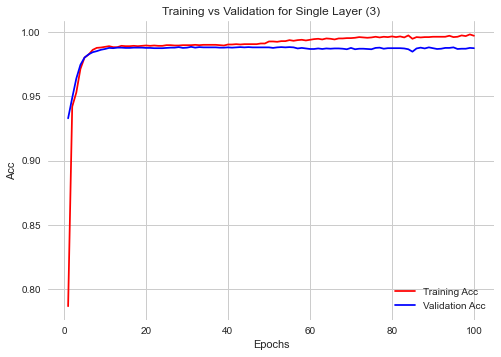

In [34]:
plotteracc(history, 'Training vs Validation for Single Layer (3)')

In [35]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Print Statistics from Confusion Matrix
from sklearn.metrics import classification_report

#create a dataframe from the classification report, using output_dict
report=classification_report(y_test, y_pred, output_dict=True)
pdReport=pd.DataFrame(report).transpose()
pdReport

,precision,recall,f1-score,support
0,0.988815,0.986364,0.987588,2420.000000
1,0.986064,0.988569,0.987315,2362.000000
accuracy,0.987453,0.987453,0.987453,0.987453
macro avg,0.987440,0.987466,0.987451,4782.000000
weighted avg,0.987456,0.987453,0.987453,4782.000000


In [36]:
seconds3 , results3, result_training3 = evaluate_model(X.values, y, classifier)

print('Accuracy: %.3f (%.3f)' % (mean(results3), std(results3)))
print('Execution time: %.3f (%.3f)' % (mean(seconds3), std(seconds3)))
print('Training: %.3f (%.3f)' % (mean(result_training3), std(result_training3)))

results=pd.DataFrame(np.array([[mean(results3), std(results3)], [mean(seconds3), std(seconds3)], [mean(result_training3), std(result_training3)]]),\
                   columns=['mean', 'std deviation'], index=['accuracy','execution time','training'])
results

Training>0.991
Test>0.984
Training>1.000
Test>0.984
Training>1.000
Test>0.996
Training>1.000
Test>0.991
Training>1.000
Test>0.995
Training>0.995
Test>0.993
Training>1.000
Test>0.997
Training>1.000
Test>0.998
Training>1.000
Test>0.991
Training>1.000
Test>0.994
Accuracy: 0.992 (0.005)
Execution time: 26.653 (1.886)
Training: 0.999 (0.003)


,mean,std deviation
accuracy,0.992159,0.004536
execution time,26.652824,1.886111
training,0.998617,0.002880
